In [1]:
# DB 
import psycopg2
from django.conf import settings
from django.db.models import Case, IntegerField, Value

# Helpers
import numpy as np
from collections import Counter, defaultdict
import pickle
import rpy2

# Learning
from sklearn.cluster import AgglomerativeClustering

# Evaluation
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext rpy2.ipython

In [2]:
folder = "data/tese/"

In [3]:
# Open automated and refined Q-matrices
with open('%s/q_matrix_automated.pkl' % folder, 'rb') as pklfile:
    q_matrix_automated = pickle.load(pklfile)
    
with open('%s/q_matrix_refined.pkl' % folder, 'rb') as pklfile:
    q_matrix_analysis = pickle.load(pklfile)
    
print(q_matrix_automated.T.shape)
print(q_matrix_analysis.T.shape)

(12, 54)
(5, 54)


In [4]:
np.savetxt("%s/q_matrix_automated.csv" % folder, q_matrix_automated, delimiter=",")
np.savetxt("%s/q_matrix_refined.csv" % folder, q_matrix_analysis, delimiter=",")

In [5]:
with open("%s/questions_idx.pkl" % folder, 'rb') as pklfile:
    questions_idx = pickle.load(pklfile)

questions_idx = np.asarray(questions_idx)
questions_idx.shape

(54,)

In [6]:
connection = psycopg2.connect(user = settings.DATABASES["default"]["USER"],
                                  password = settings.DATABASES["default"]["PASSWORD"],
                                  host = settings.DATABASES["default"]["HOST"],
                                  port = settings.DATABASES["default"]["PORT"],
                                  database = settings.DATABASES["default"]["NAME"])
connection.autocommit=True
cursor = connection.cursor()

In [7]:
# Filter used problems and solutions
last_id = 132
problems = Problem.objects.filter(id__lte=last_id)
solutions = Solution.objects.filter(problem__in=problems, ignore=False).values_list('problem', flat=True)
problems = solutions.order_by('problem').values_list(
    'problem', flat=True).distinct('problem')
print("Total number of questions: %d" % problems.count())

# Get all students
user_blacklist = UserProfile.objects.filter(professor__user__username='sem_professor')

attempts = UserLog.objects.exclude(outcome='S').filter(
    timestamp__lt=OuterRef('timestamp'), user__id=OuterRef('user__id')).annotate(
    attempt=Count('*')).values('attempt')

# Remove group by values
attempts.query.set_group_by()

# Get users
users = UserLog.objects.filter(problem__in=problems).exclude(outcome='S').exclude(
    user__userprofile__in=user_blacklist).annotate(
    attempt=Subquery(attempts, output_field=IntegerField())).annotate(
    score=Case(
        When(outcome='F', then=Value(0.1)),
        When(outcome='P', then=Value(1)),
        output_field=IntegerField())).values_list(
    "user__id", "problem_id", "attempt", "score"#"outcome", "timestamp"
).order_by("timestamp").filter(attempt=1).values_list('user_id', flat=True)

cluster_data = UserLog.objects.filter(problem__in=problems).exclude(outcome='S').annotate(
    attempt=Subquery(attempts, output_field=IntegerField())).annotate(
    score=Case(
        When(outcome='F', then=Value(0)),
        When(outcome='P', then=Value(1)),
        output_field=IntegerField())).order_by("timestamp").filter(user__in=users)

attempts_total = cluster_data.count()
print("Total number of attempts: %d" % attempts_total)

Total number of questions: 48
Total number of attempts: 3632


In [8]:
# Get voted concepts per solution
concepts = SolutionConcept.objects.all()
count = concepts.values_list('solution').annotate(count=Count('user', distinct=True))
sol_id, eval_count = zip(*list(count))

# Get voted concepts per problem
concepts = SolutionConcept.objects.all()
count = concepts.values_list('solution__problem').annotate(count=Count('user', distinct=True))
sol_id, eval_count = zip(*list(count))

# Count concept agreement per problem
count_per_problem = dict(concepts.values_list('solution__problem').annotate(
    count=Count('user', distinct=True)))

MIN_THRESHOLD = 0.5
agreed_concepts = defaultdict(list)
agreed_concepts_len = {}

# Filter out the concepts that didn't have agreement (50% of evaluators voted for it)
for problem in problems:
    max_votes = count_per_problem[problem]
    concepts_per_problem = dict(concepts.filter(solution__problem=problem).values_list('concept').annotate(
        count=Count("concept")))
    for concept, value in concepts_per_problem.items():
        if value >= (max_votes * MIN_THRESHOLD):
            agreed_concepts[problem].append(concept)
    agreed_concepts_len[problem] = len(agreed_concepts[problem])

In [9]:
%%R
library(factoextra)
library(proxy)

R[write to console]: Loading required package: ggplot2

R[write to console]: Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

R[write to console]: 
Attaching package: ‘proxy’


R[write to console]: The following objects are masked from ‘package:stats’:

    as.dist, dist


R[write to console]: The following object is masked from ‘package:base’:

    as.matrix




In [10]:
%%R
getwd()

[1] "/home/lmoraes/machine-teaching/machineteaching"


In [192]:
%%R -o clusters
data <- read.csv('data/tese/q_matrix_automated.csv', header=FALSE)
# data <- read.csv('data/tese/q_matrix_automated.csv', header=FALSE)
# data <- read.csv('data/tese/q_matrix_refined.csv', header=FALSE)
# data <- as.data.frame(t(as.matrix(data)))

# res.dist <- dist(data, method = "jaccard")
res.dist <- dist(data, method = "euclidean")
res.hc <- hclust(d=res.dist, method = "ward.D2")

options(repr.plot.width=4, repr.plot.height=3)
k <- 14
clusters <- cutree(res.hc, k)

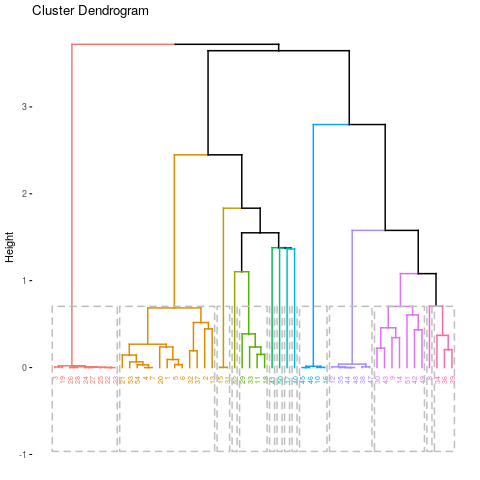

In [193]:
%%R
fviz_dend(res.hc, 
          k = k,
          cex = 0.5, 
          color_labels_by_k = TRUE,
          rect = TRUE)

In [194]:
clusters

array([ 1,  1,  2,  1,  1,  1,  1,  3,  4,  5,  6,  7,  1,  4,  8,  5,  9,
        6,  2,  1,  1,  2,  2,  2,  2,  2,  2,  2,  6,  4,  8,  1,  6, 10,
        7, 10,  1,  7, 10, 11, 12,  4,  4,  7,  5,  5,  7,  7,  4, 13,  4,
       14,  1,  1], dtype=int32)

In [195]:
unique_clusters = set(clusters)
unique_clusters

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

Redoing attempts statistics

In [230]:
%%time
points = []

success_per_question_cluster = defaultdict(dict)
for i, cluster in enumerate(unique_clusters):
    q_idx = questions_idx[np.where(clusters == cluster)]

    # Filter cluster problems
    problems = Problem.objects.filter(id__in=q_idx)
    print("Total number of questions: %d" % problems.count())
    
    # Get concepts
    concept_c = defaultdict(int)
    for problem in problems:
        print(agreed_concepts[problem.id])
        conc = agreed_concepts[problem.id]
        for c in conc:
            concept_c[c] += 1
    cs, votes = zip(*list(concept_c.items()))
    best_c = np.asarray(cs)[np.where(np.asarray(votes) >= 0.6*problems.count())]
    print("Concepts: %s" % best_c)
    print(concept_c)

    # Get attempts
    attempts = cluster_data.filter(problem__in=problems).values_list(
        "user__id", "problem_id", "attempt", "score")
    
    # Get students
    user = set(cluster_data.filter(problem__in=problems).values_list('user__id', flat=True))
    
    attempts_count = attempts.count()
    attempts_avg = attempts_count/len(user)/problems.count()
#     users_total = users.count()
    success_attempts = attempts.filter(score=1)
    fail_attempts = attempts.filter(score=0)

    print("Total of %d attempts" % attempts_count)
    print("Total percentage of attempts: %.2f" % (attempts_count/attempts_total*100))
#     print("Total of %d students" % users_total)
#     print("Average of attempt per student: %.2f" % (attempts_total/users_total))
    success_perc = success_attempts.count()/attempts_count
    print("Success attempts: %d (%.2f%%)" % (success_attempts.count(), 100*success_perc))
#     print("Failed attempts: %d (%.2f%%)" % (fail_attempts.count(), 100*fail_attempts.count()/attempts_count))
#     print()
    
#     success_per_student = defaultdict(int)
#     fail_per_student = defaultdict(int)
#     success_per_question = defaultdict(int)
#     fail_per_question = defaultdict(int)

#     for row in success_attempts:
#         s_idx, q_idx, a_idx, outcome = row
#         success_per_student[s_idx] += 1
#         success_per_question[q_idx] += 1


#     for row in fail_attempts:
#         s_idx, q_idx, a_idx, outcome = row
#         fail_per_student[s_idx] += 1
#         fail_per_question[q_idx] += 1
        
#     success_per_question_cluster[i] = success_per_question

#     min_student_success_attempt = min(success_per_student.values())
#     max_student_success_attempt = max(success_per_student.values())
#     avg_student_success_attempt = np.mean(list(success_per_student.values()))
#     min_student_fail_attempt = min(fail_per_student.values())
#     max_student_fail_attempt = max(fail_per_student.values())
#     avg_student_fail_attempt = np.mean(list(fail_per_student.values()))

#     min_question_success_attempt = min(success_per_question.values())
#     max_question_success_attempt = max(success_per_question.values())
#     avg_question_success_attempt = np.mean(list(success_per_question.values()))
#     median_question_success_attempt = np.median(list(success_per_question.values()))
#     min_question_fail_attempt = min(fail_per_question.values())
#     max_question_fail_attempt = max(fail_per_question.values())
#     avg_question_fail_attempt = np.mean(list(fail_per_question.values()))
#     median_question_fail_attempt = np.median(list(fail_per_question.values()))

#     print("Min student success attempt: %d" % min_student_success_attempt)
#     print("Max student success attempt: %d" % max_student_success_attempt)
#     print("Avg student success attempt: %.2f" % avg_student_success_attempt)

#     print("Min student fail attempt: %d" % min_student_fail_attempt)
#     print("Max student fail attempt: %d" % max_student_fail_attempt)
#     print("Avg student fail attempt: %.2f" % avg_student_fail_attempt)

#     print("Min question success attempt: %d" % min_question_success_attempt)
#     print("Max question success attempt: %d" % max_question_success_attempt)
#     print("Avg question success attempt: %.2f" % avg_question_success_attempt)
#     print("Median question success attempt: %.2f" % median_question_success_attempt)

#     print("Min question fail attempt: %d" % min_question_fail_attempt)
#     print("Max question fail attempt: %d" % max_question_fail_attempt)
#     print("Avg question fail attempt: %.2f" % avg_question_fail_attempt)
#     print("Median question fail attempt: %.2f" % median_question_fail_attempt)
    print("Number of students: %d" % len(user))
    print()
#     c_str = [str(c) for c in best_c.tolist()]
#     print(c_str)
    points.append([attempts_avg, success_perc, len(user), best_c.tolist()])
#     points.append([attempts_avg, success_perc, len(user), ", ".join(c_str)])

Total number of questions: 13
[11, 12, 5]
[14, 1, 8]
[14, 7, 8]
[14, 12, 2]
[9, 3, 5]
[6, 11, 7, 12]
[14, 3, 5]
[14, 12, 7, 10]
[14, 1, 3, 5]
[14, 1, 3, 5]
[14, 1, 3, 7]
[14, 1, 3, 5]
[14, 7]
Concepts: [14]
defaultdict(<class 'int'>, {11: 2, 12: 4, 5: 6, 14: 10, 1: 5, 8: 2, 7: 5, 2: 1, 9: 1, 3: 6, 6: 1, 10: 1})
Total of 589 attempts
Total percentage of attempts: 16.22
Success attempts: 185 (31.41%)
Number of students: 88

Total number of questions: 9
[6, 11, 14, 5]
[6, 11, 14, 7]
[11, 14]
[6, 11, 14, 3, 9]
[6, 11, 14, 4]
[11, 14]
[6, 11, 14, 5]
[11, 7, 12]
[11, 7, 12]
Concepts: [11 14]
defaultdict(<class 'int'>, {6: 5, 11: 9, 14: 7, 5: 2, 7: 3, 3: 1, 9: 1, 4: 1, 12: 2})
Total of 481 attempts
Total percentage of attempts: 13.24
Success attempts: 137 (28.48%)
Number of students: 84

Total number of questions: 1
[11, 8, 12]
Concepts: [11  8 12]
defaultdict(<class 'int'>, {11: 1, 8: 1, 12: 1})
Total of 60 attempts
Total percentage of attempts: 1.65
Success attempts: 25 (41.67%)
Number of s

In [220]:
import pandas as pd
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.express as px
import math
import plotly.graph_objects as go

In [231]:
df = pd.DataFrame(points, columns=["Attempts", "Success rate", 
                                   "Students", "Concepts"])
df

,Attempts,Success rate,Students,Concepts
0,0.514860,0.314092,88,[14]
1,0.636243,0.284823,84,"[11, 14]"
2,2.222222,0.416667,27,"[11, 8, 12]"
3,0.900752,0.156928,95,[12]
4,1.486301,0.154378,73,"[11, 12]"
5,1.344828,0.169872,58,[]
6,1.075214,0.248013,117,"[7, 5]"
7,4.906250,0.101911,16,"[11, 12]"
8,2.281250,0.383562,32,"[6, 11, 12, 8]"
9,2.038095,0.158879,35,"[14, 12, 5]"


In [198]:
hover_text = []
bubble_size = []

for index, row in df.iterrows():
    hover_text.append(('Concepts: {Concepts}<br>'+
                      'Students: {Students}<br>'+
                      'Success Rate: {success_rate}%<br>'+
                      'Avg. attempts: {Attempts}').format(Concepts=row['Concepts'],
                                                          Students=row['Students'],
                                                          success_rate=round(row['Success rate']*100,2),
                                                          Attempts=round(row['Attempts'],2)
                                                         ))
    bubble_size.append(row['Students']*20)
    
df['text'] = hover_text
df['size'] = bubble_size

In [199]:
label_lookup = {(11,14): "Conditional",
                (12,): "Loop",
                (12, 5): "Loop in math problems",
                (11, 8, 12): "Conditional and Loop in lists",
                (6, 11, 8, 12): "Conditional and Loop in lists",
                (11, 12): "Conditional and Loop",
                (7, 11): "Conditional in strings",
                (0,): "No agreement",
                (14, 3): "Functions using numbers",
                (14, ): "Functions",
                (14, 7, 8): "Functions for string and lists",
                (3, 5): "Math",
                (13,): "Nested loops",
               }

# # Dictionary with dataframes for each continent
# concept_data = {key: df.query("Concept == '%s'" %continent)
#                               for key in label_lookup.keys()}

In [200]:
# df.query("Concept == '%s'" %continent)

In [201]:
# Create figure
fig = go.Figure()
fig.add_trace(go.Scatter(
        x=df['Attempts'], y=df['Success rate'],
        text=df['text'],
        marker_size=df['size'],
        ))
# Tune marker appearance and layout
fig.update_traces(mode='markers', marker=dict(sizemode='area',
#                                               sizeref=sizeref, 
                                              line_width=2))

In [232]:
points

[[0.5148601398601399, 0.3140916808149406, 88, [14]],
 [0.6362433862433863, 0.28482328482328484, 84, [11, 14]],
 [2.2222222222222223, 0.4166666666666667, 27, [11, 8, 12]],
 [0.9007518796992481, 0.15692821368948248, 95, [12]],
 [1.4863013698630136, 0.1543778801843318, 73, [11, 12]],
 [1.3448275862068966, 0.16987179487179488, 58, []],
 [1.0752136752136754, 0.2480127186009539, 117, [7, 5]],
 [4.90625, 0.10191082802547771, 16, [11, 12]],
 [2.28125, 0.3835616438356164, 32, [6, 11, 12, 8]],
 [2.038095238095238, 0.1588785046728972, 35, [14, 12, 5]],
 [5.916666666666667, 0.11267605633802817, 12, [14, 7, 8]],
 [64.0, 0.015625, 4, [12]],
 [4.115942028985507, 0.20422535211267606, 69, [12]],
 [5.416666666666667, 0.1076923076923077, 12, [12, 5]]]

In [246]:
label_lookup = {(11,14): "Conditional",
                (12,): "Loop",
                (12, 5): "Loop in math problems",
                (11, 8, 12): "Conditional and Loop in lists",
                (6, 11, 12, 8): "Conditional and Loop in lists",
                (11, 12): "Conditional and Loop",
                (7, 11): "Conditional in strings",
                (0,): "No agreement",
                (14, 3): "Functions using numbers",
                (14, ): "Functions",
                (14, 7, 8): "Functions for string and lists",
                (14, 12, 5): "Loop in math problems",
                (5, ): "Math",
                (7, 5): "Math and string",
                (13,): "Nested loops",
                (8, ): "Lists"
               }

labels = []
for i in points:
    try:
        labels.append(label_lookup[tuple(i[3],)])
    except KeyError:
        labels.append("No agreement")
        
unique_labels = list(set(labels))
unique_labels.sort()
unique_labels

['Conditional',
 'Conditional and Loop',
 'Conditional and Loop in lists',
 'Functions',
 'Functions for string and lists',
 'Loop',
 'Loop in math problems',
 'Math and string',
 'No agreement']

In [278]:
ccolors = plt.get_cmap('tab10')(np.linspace(0,1,9))
# Swap so gray is in the end
a, b = ccolors[8].copy(), ccolors[6].copy()
ccolors[6], ccolors[8] = a, b

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

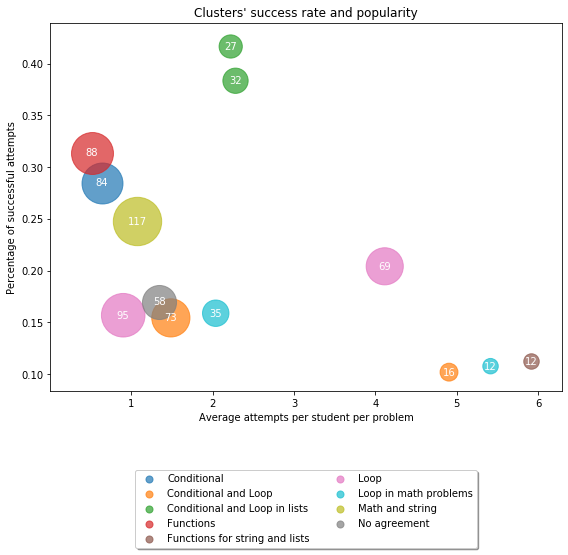

In [281]:
x = np.asarray([item[0] for item in points])
y = np.asarray([item[1] for item in points])
s = np.asarray([item[2] for item in points])

fig, ax = plt.subplots(figsize=(8,8))

for k, l in enumerate(unique_labels):
    idx = []
    for i, item in enumerate(points):
        # Remove outlier
        if item[2] == 4:
            continue
        if labels[i] == l:
            idx.append(i)
    #   Hack to pretty print
#     x[np.where(s == 62)] = 6.2
#     y[np.where(x == 462)] = 0.24
#     if l == "No agreement":
#             ax.scatter(x[idx], y[idx], s[idx]*20, alpha=0.7, label=l, color='gray')
#     else:
    ax.scatter(x[idx], y[idx], s[idx]*20, alpha=0.7, label=l, color=ccolors[k])
            
for idx in range(len(x)):
    # Remove outlier
    if s[idx] == 4:
        continue
    text = ax.text(x[idx], y[idx], s[idx], ha="center", va="center", color="w")

ax.set_title("Clusters' success rate and popularity")
ax.set_xlabel("Average attempts per student per problem")
ax.set_ylabel("Percentage of successful attempts")
plt.set_cmap('tab10')
# Put a legend below current axis
lgnd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)
# lgnd = plt.legend()
for handle in lgnd.legendHandles:
    handle._sizes = [50]
    
plt.tight_layout()
plt.savefig('data/tese/cluster_success.eps', format='eps')
plt.savefig('data/tese/cluster_success.png', format='png')
plt.show()

So it is possible to think of it as four quadrants: on the top left are the easy questions (high successfully attempts percentage and attempts on average); on the bottom left are the medium questions (questions with low success rate but also a low attempts average); on the top right there are not any questions (it would be questions with high success rate but also a high number of tries, which in unlikely) and finally, on the bottom right are the questions where students have more difficulties. Analyzing by the quadrants, the gray cluster (top left) require the use of the ``Function'' concept, which are introductory CS1 exercises where the student is suppose to write a function with simple math operations directly in the return statement. The exercises belonging to this cluster are solved in smaller number of attempts and have a high success rate when compared to the other clusters. The clusters around 5 to 6.5 attempts on average are the very popular among students. They involve more advanced concepts such as strings, loops and conditionals and, on average, a student submits a correct response to them after 4 to 5 attempts. Finally, there are two clusters with more than 7 attempts on average per student and very low success rate. These clusters work on the ``Loop''  and ``Nested Loop'' concepts and have more complex problems than the other orange cluster.